In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


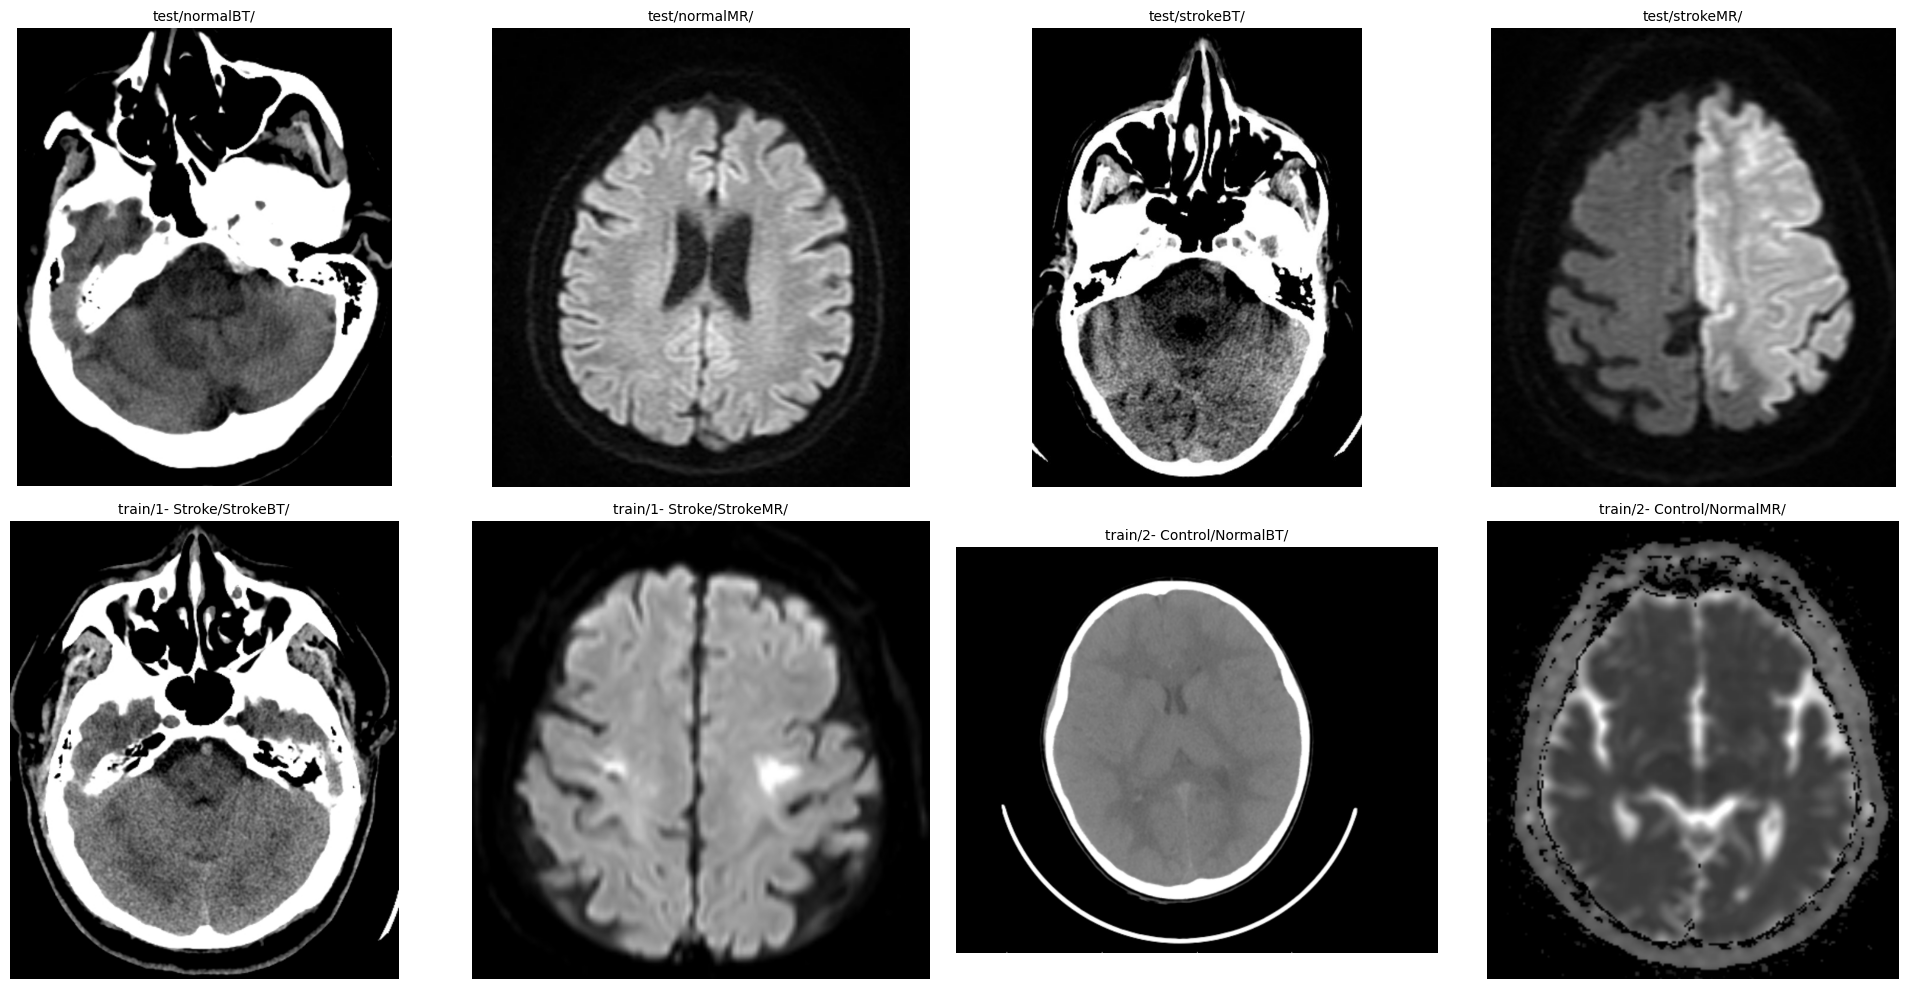

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# Define the base path to your dataset
dataset_path = '/content/drive/MyDrive/Multi_Dataset/deep/'

# List all the subfolders you want to display an image from
subfolders = [
    'test/normalBT/',
    'test/normalMR/',
    'test/strokeBT/',
    'test/strokeMR/',
    'train/1- Stroke/StrokeBT/',
    'train/1- Stroke/StrokeMR/',
    'train/2- Control/NormalBT/',
    'train/2- Control/NormalMR/'
]

# Set up the plot for displaying all images
# We'll create a figure with 2 rows and 4 columns
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten() # Flatten the 2x4 array of axes for easy iteration

# Loop through each subfolder to find and display one image
for i, subfolder in enumerate(subfolders):
    full_path = os.path.join(dataset_path, subfolder)

    # Get a list of all files in the current directory
    file_list = os.listdir(full_path)

    # Find the first image file (assuming .png or .jpg)
    image_file = None
    for file_name in file_list:
        if file_name.endswith('.png') or file_name.endswith('.jpg'):
            image_file = file_name
            break

    if image_file:
        image_path = os.path.join(full_path, image_file)

        # Read the image using OpenCV (which reads in BGR format)
        image = cv2.imread(image_path)

        # Convert the image from BGR to RGB for correct display with Matplotlib
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Display the image on the current subplot
        axes[i].imshow(image_rgb)
        axes[i].set_title(subfolder, fontsize=10)
        axes[i].axis('off') # Hide the axis ticks and labels

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

Found 5336 total images. Balanced dataset has 5282 images.
Normal images: 2641, Stroke images: 2641
Generation 1/2


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  Best fitness in generation: 0.8795
Generation 2/2


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  Best fitness in generation: 0.9084
GA optimization complete.
Evaluating best chromosome on test set...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Test Accuracy (Best Chromosome): 0.8657
Test AUC (Best Chromosome): 0.9432
Test Precision (Best Chromosome): 0.9142
Test Recall (Best Chromosome): 0.8068
Test F1 Score (Best Chromosome): 0.8571


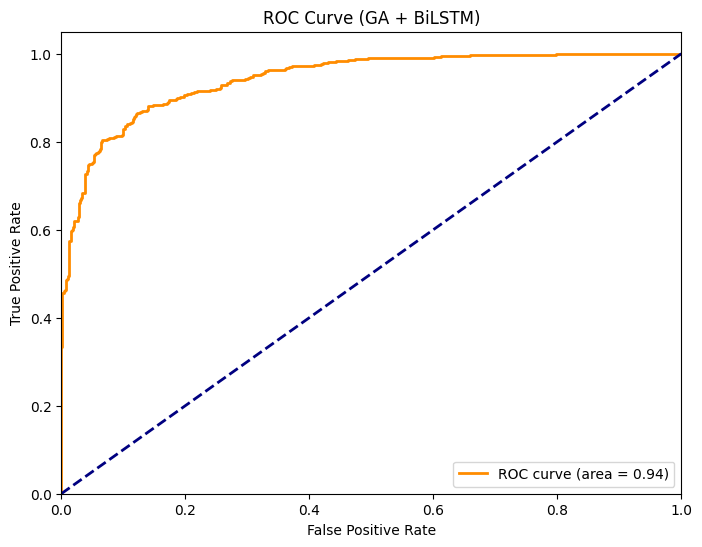

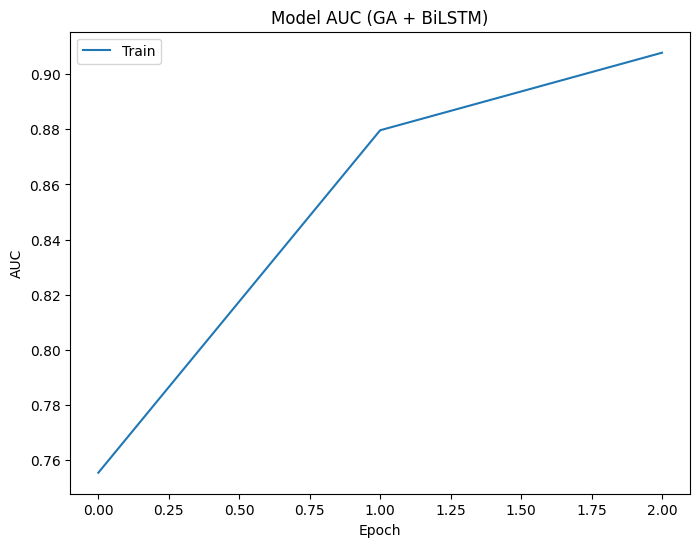

Models-GA_BiLSTM
Accuracy-0.87
Precision- 0.91
Recall- 0.81
F1-score- 0.86
Model saved to GA_BiLSTM_New.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_score, recall_score, f1_score
from PIL import Image
import kagglehub
import matplotlib.pyplot as plt
import gc
import cv2

# Define dataset path (adjust this to your local path)
# Assuming your Google Drive is mounted, this path should be correct
DATASET_PATH = "/content/drive/MyDrive/Multi_Dataset/deep/"
IMAGE_SIZE = (128, 128)
# GA Parameters
POPULATION_SIZE = 3
NUM_GENERATIONS = 2
MUTATION_RATE = 0.1
# BiLSTM Training Parameters
BILSTM_EPOCHS = 3
BILSTM_BATCH_SIZE = 16
MAX_FEATURES = 200

# Define Model File to save model
MODEL_SAVE_PATH = "GA_BiLSTM_New.h5"

# -----------------------------------------------------------------------
# 1. Data Loading and Preprocessing (FIXED SECTION)
# -----------------------------------------------------------------------
def load_and_preprocess_data_custom(dataset_path, image_size):
    """Loads and preprocesses images from the custom nested dataset structure."""
    all_images = []
    labels = []

    # Class mapping based on folder names
    class_mapping = {
        'normal': 0, 'Normal': 0, '2- Control': 0, 'normalBT': 0, 'NormalBT': 0, 'normalMR': 0, 'NormalMR': 0,
        'stroke': 1, 'Stroke': 1, '1- Stroke': 1, 'strokeBT': 1, 'StrokeBT': 1, 'strokeMR': 1, 'StrokeMR': 1
    }

    # Walk through the directory tree
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            # Check if the file is an image and handle case sensitivity
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(root, file)
                # Determine the label from the parent directory name
                parent_folder = os.path.basename(os.path.dirname(image_path))
                label = class_mapping.get(parent_folder)

                # If the immediate parent folder name is not in the map, check higher up
                if label is None:
                    grandparent_folder = os.path.basename(os.path.dirname(os.path.dirname(image_path)))
                    label = class_mapping.get(grandparent_folder)

                if label is not None:
                    try:
                        img = Image.open(image_path).convert('L')  # Convert to grayscale
                        img = img.resize(image_size)
                        img_array = np.array(img) / 255.0  # Normalize
                        all_images.append(img_array)
                        labels.append(label)
                    except Exception as e:
                        print(f"Error processing image {image_path}: {e}")
                else:
                    # Optional: Print folders that were not mapped
                    # print(f"Warning: Could not determine label for {image_path}. Parent folder: {parent_folder}")
                    pass

    # Balance the dataset
    df = pd.DataFrame({'image': all_images, 'label': labels})
    normal_df = df[df['label'] == 0].sample(n=min(len(df[df['label'] == 0]), len(df[df['label'] == 1])), random_state=42)
    stroke_df = df[df['label'] == 1].sample(n=min(len(df[df['label'] == 0]), len(df[df['label'] == 1])), random_state=42)
    balanced_df = pd.concat([normal_df, stroke_df]).sample(frac=1, random_state=42).reset_index(drop=True)

    print(f"Found {len(df)} total images. Balanced dataset has {len(balanced_df)} images.")
    print(f"Normal images: {len(balanced_df[balanced_df['label'] == 0])}, Stroke images: {len(balanced_df[balanced_df['label'] == 1])}")

    return np.array(list(balanced_df['image'])), np.array(list(balanced_df['label']))

# Load data
try:
    data, labels = load_and_preprocess_data_custom(DATASET_PATH, IMAGE_SIZE)
except FileNotFoundError:
    print(f"Dataset not found at {DATASET_PATH}. Please check the path and mount your Google Drive.")
    exit()

# Handle empty data
if len(data) == 0:
    print("No images were found or loaded. Exiting.")
    exit()

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)

# Reshape data for LSTM input (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1] * X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1] * X_test.shape[2]))
NUM_FEATURES = X_train.shape[2]

# -----------------------------------------------------------------------
# The rest of the code remains the same as your original script
# -----------------------------------------------------------------------

def create_chromosome(num_features):
    """Creates a random binary chromosome."""
    chromosome = np.zeros(num_features, dtype=int)
    indices = np.random.choice(num_features, min(MAX_FEATURES, num_features), replace=False)
    chromosome[indices] = 1
    np.random.shuffle(chromosome)
    return chromosome

def fitness_function(chromosome, X_train, y_train, X_val, y_val):
    """Evaluates the fitness of a chromosome (feature subset)."""
    selected_features = np.where(chromosome == 1)[0]
    if len(selected_features) == 0:
        return 0.0, None
    X_train_subset = X_train[:, :, selected_features]
    X_val_subset = X_val[:, :, selected_features]

    model = Sequential([
        Bidirectional(LSTM(32, return_sequences=True), input_shape=(1, len(selected_features))),
        Bidirectional(LSTM(16)),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
    history = model.fit(X_train_subset, y_train, epochs=BILSTM_EPOCHS, batch_size=BILSTM_BATCH_SIZE, verbose=0)
    y_pred_val = model.predict(X_val_subset, verbose=0)
    auc = roc_auc_score(y_val, y_pred_val)
    tf.keras.backend.clear_session()
    gc.collect()
    return auc, history

def selection(population, fitness_scores, num_parents):
    """Selects the best chromosomes based on fitness using tournament selection."""
    parents = []
    for _ in range(num_parents):
        tournament_size = 3
        tournament_indices = np.random.choice(len(population), tournament_size, replace=False)
        tournament_fitnesses = fitness_scores[tournament_indices]
        winner_index = tournament_indices[np.argmax(tournament_fitnesses)]
        parents.append(population[winner_index])
        fitness_scores[winner_index] = -1
    return np.array(parents)

def crossover(parents, population_size, num_features):
    """Creates offspring chromosomes through crossover."""
    offspring = []
    for _ in range(population_size - len(parents)):
        parent1 = random.choice(parents)
        parent2 = random.choice(parents)
        crossover_point = random.randint(1, num_features - 1)
        child = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
        offspring.append(child)
    return np.array(offspring)

def mutation(offspring, mutation_rate):
    """Introduces random changes (mutation) in the offspring."""
    mutated_offspring = []
    for individual in offspring:
        for i in range(len(individual)):
            if random.random() < mutation_rate:
                individual[i] = 1 - individual[i]
        mutated_offspring.append(individual)
    return np.array(mutated_offspring)

# -----------------------------------------------------------------------
# 4. GA Training and Evaluation
# -----------------------------------------------------------------------

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
population = np.array([create_chromosome(NUM_FEATURES) for _ in range(POPULATION_SIZE)])

best_chromosome = None
best_fitness = -1.0
best_history = None

for generation in range(NUM_GENERATIONS):
    print(f"Generation {generation + 1}/{NUM_GENERATIONS}")
    fitness_results = [fitness_function(chromosome, X_train, y_train, X_val, y_val) for chromosome in population]
    fitness_scores = np.array([result[0] if result[0] is not None else 0 for result in fitness_results])
    histories = [result[1] for result in fitness_results]

    current_best_fitness = np.max(fitness_scores)
    current_best_chromosome = population[np.argmax(fitness_scores)]
    current_best_history = histories[np.argmax(fitness_scores)]
    if current_best_fitness > best_fitness:
        best_fitness = current_best_fitness
        best_chromosome = current_best_chromosome
        best_history = current_best_history

    print(f"  Best fitness in generation: {current_best_fitness:.4f}")

    parents = selection(population, fitness_scores.copy(), POPULATION_SIZE // 2)
    offspring = crossover(parents, POPULATION_SIZE, NUM_FEATURES)
    offspring = mutation(offspring, MUTATION_RATE)

    population[:len(parents)] = parents
    population[len(parents):] = offspring[:POPULATION_SIZE - len(parents)]

print("GA optimization complete.")

# -----------------------------------------------------------------------
# 5. Evaluate Best Chromosome on Test Set
# -----------------------------------------------------------------------
print("Evaluating best chromosome on test set...")
if best_chromosome is None:
    print("No valid chromosome found. Exiting.")
    exit()

selected_features = np.where(best_chromosome == 1)[0]
if len(selected_features) == 0:
    print("Best chromosome has no features. Exiting.")
    exit()

X_test_subset = X_test[:, :, selected_features]
X_train_subset = X_train[:, :, selected_features]

final_model = Sequential([
        Bidirectional(LSTM(32, return_sequences=True), input_shape=(1, len(selected_features))),
        Bidirectional(LSTM(16)),
        Dense(1, activation='sigmoid')
])
final_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC', 'Accuracy'])

history = final_model.fit(X_train_subset, y_train, epochs=10, batch_size=BILSTM_BATCH_SIZE, verbose=0)

y_pred_test = final_model.predict(X_test_subset, verbose=0)
y_pred_test_binary = (y_pred_test > 0.5).astype(int)

test_accuracy = accuracy_score(y_test, y_pred_test_binary)
test_auc = roc_auc_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test_binary)
test_recall = recall_score(y_test, y_pred_test_binary)
test_f1score = f1_score(y_test, y_pred_test_binary)

print(f"Test Accuracy (Best Chromosome): {test_accuracy:.4f}")
print(f"Test AUC (Best Chromosome): {test_auc:.4f}")
print(f"Test Precision (Best Chromosome): {test_precision:.4f}")
print(f"Test Recall (Best Chromosome): {test_recall:.4f}")
print(f"Test F1 Score (Best Chromosome): {test_f1score:.4f}")

# -----------------------------------------------------------------------
# 6. Visualization
# -----------------------------------------------------------------------

fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (GA + BiLSTM)')
plt.legend(loc="lower right")
plt.show()

if best_history is not None:
    plt.figure(figsize=(8, 6))
    plt.plot(best_history.history['AUC'])
    plt.title('Model AUC (GA + BiLSTM)')
    plt.ylabel('AUC')
    plt.xlabel('Epoch')
    plt.legend(['Train'], loc='upper left')
    plt.show()
else:
    print("No validation history available to plot.")

print(f"Models-GA_BiLSTM")
print(f"Accuracy-{test_accuracy:.2f}")
print(f"Precision- {test_precision:.2f}")
print(f"Recall- {test_recall:.2f}")
print(f"F1-score- {test_f1score:.2f}")

# -----------------------------------------------------------------------
# 7. Save Model
# -----------------------------------------------------------------------

final_model.save(MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")
from google.colab import files
files.download(MODEL_SAVE_PATH)

In [ ]:
# Save the best chromosome as a NumPy file
if best_chromosome is not None:
    np.save("best_chromosome.npy", best_chromosome)
    print("Best chromosome saved to best_chromosome.npy")
    # This line is for Google Colab to download the file to your local machine
    from google.colab import files
    files.download("best_chromosome.npy")

Best chromosome saved to best_chromosome.npy


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model loaded successfully.
Best chromosome loaded successfully.


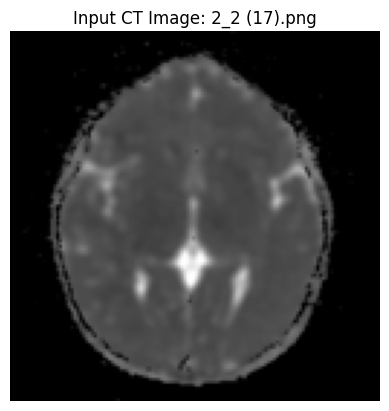

Prediction Probability: 0.0148
Predicted Class: Normal 🧠


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from PIL import Image

# =======================================================================
# 1. Load Model & Chromosome
# =======================================================================
# Ensure these files are in your Colab environment or provide their correct paths
MODEL_PATH = "/content/GA_BiLSTM_New.h5"
CHROMOSOME_PATH = "/content/best_chromosome.npy"

try:
    # Load the trained BiLSTM model
    model = load_model(MODEL_PATH)
    print("Model loaded successfully.")

    # Load the best chromosome (feature selection mask) from the GA training
    best_chromosome = np.load(CHROMOSOME_PATH)
    selected_features = np.flatnonzero(best_chromosome)
    print("Best chromosome loaded successfully.")

except FileNotFoundError:
    print("Error: Model or chromosome file not found. Please ensure the paths are correct.")
    # Exit the script if files are not found
    exit()

# =======================================================================
# 2. Preprocess Function
# =======================================================================
def preprocess_image(image_path, image_size=(128, 128), selected_features=None):
    """
    Loads, preprocesses, and resizes a single image for prediction.
    Applies the GA-selected features to the flattened image data.
    """
    try:
        # Open and convert the image to grayscale
        img = Image.open(image_path).convert('L')
        # Resize the image to match the model's input size
        img = img.resize(image_size)
        # Convert to a NumPy array and normalize pixel values
        img_array = np.array(img) / 255.0

        # Display the input image for verification
        plt.imshow(img_array, cmap='gray')
        plt.title(f"Input CT Image: {os.path.basename(image_path)}")
        plt.axis('off')
        plt.show()

        # Flatten the image array into a 1D vector
        flat_img = img_array.flatten()

        # Apply the feature selection mask from the best chromosome
        if selected_features is not None:
            flat_img = flat_img[selected_features]

        # Reshape for the BiLSTM model input: (samples, time steps, features)
        # Here, samples=1, time steps=1, and features = number of selected pixels
        return flat_img.reshape(1, 1, -1)

    except Exception as e:
        print(f"Error processing image: {e}")
        return None

# =======================================================================
# 3. Prediction
# =======================================================================
# Path to the image you want to predict
image_path = "/content/2_2 (17).png"  # <- Change this to your test image path

# Preprocess the image
processed_img = preprocess_image(image_path, selected_features=selected_features)

if processed_img is not None:
    # Make a prediction with the loaded model
    pred_prob = model.predict(processed_img, verbose=0)[0][0]

    # Determine the predicted class based on the probability
    pred_class = "Stroke" if pred_prob > 0.5 else "Normal"

    # Print the prediction results
    print(f"Prediction Probability: {pred_prob:.4f}")
    print(f"Predicted Class: {pred_class} 🧠")

**GA and Bidirectional GRU**

Found 5336 total images. Balanced dataset has 5282 images.
Normal images: 2641, Stroke images: 2641
Generation 1/2


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  Best fitness in generation: 0.8676
Generation 2/2


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  Best fitness in generation: 0.9233
GA optimization complete.
Evaluating best chromosome on test set...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Test Accuracy (Best Chromosome-BiGRU): 0.8694
Test AUC (Best Chromosome-BiGRU): 0.9464
Test Precision (Best Chromosome-BiGRU): 0.8931
Test Recall (Best Chromosome-BiGRU): 0.8390
Test F1 Score (Best Chromosome-BiGRU): 0.8652


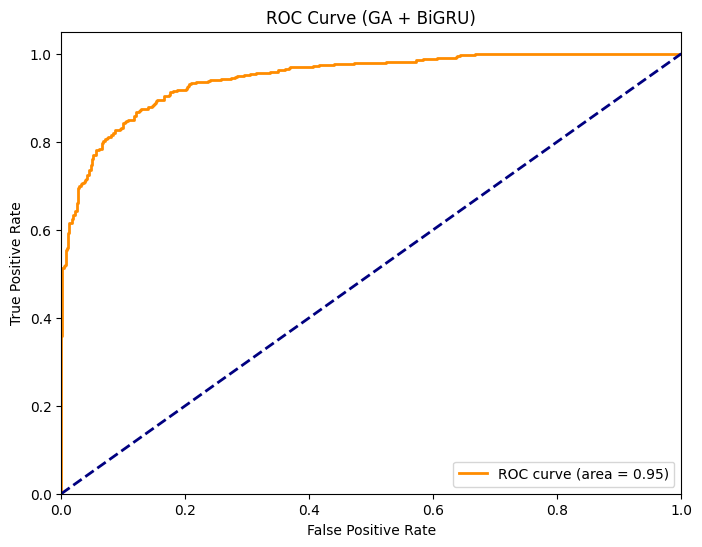

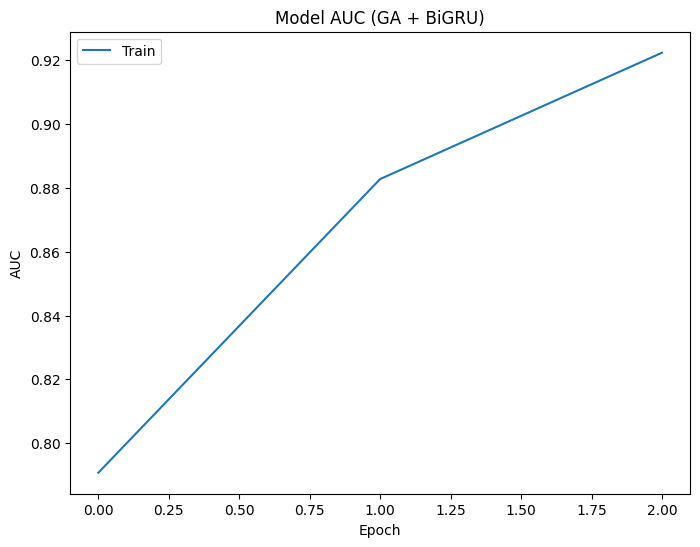

Models-GA_BiGRU
Accuracy-0.87
Precision- 0.89
Recall- 0.84
F1-score- 0.87
Model saved to GA_BiGRU.h5


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Bidirectional, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_score, recall_score, f1_score
from PIL import Image
import matplotlib.pyplot as plt
import gc

# Dataset parameters
DATASET_PATH = "/content/drive/MyDrive/Multi_Dataset/deep/"
IMAGE_SIZE = (128, 128)
POPULATION_SIZE = 3
NUM_GENERATIONS = 2
MUTATION_RATE = 0.1
GRU_EPOCHS = 3
GRU_BATCH_SIZE = 16
MAX_FEATURES = 200
MODEL_SAVE_PATH = "GA_BiGRU.h5"

def load_and_preprocess_data_custom(dataset_path, image_size):
    all_images = []
    labels = []
    class_mapping = {
        'normal': 0, 'Normal': 0, '2- Control': 0, 'normalBT': 0, 'NormalBT': 0, 'normalMR': 0, 'NormalMR': 0,
        'stroke': 1, 'Stroke': 1, '1- Stroke': 1, 'strokeBT': 1, 'StrokeBT': 1, 'strokeMR': 1, 'StrokeMR': 1
    }
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(root, file)
                parent_folder = os.path.basename(os.path.dirname(image_path))
                label = class_mapping.get(parent_folder)
                if label is None:
                    grandparent_folder = os.path.basename(os.path.dirname(os.path.dirname(image_path)))
                    label = class_mapping.get(grandparent_folder)
                if label is not None:
                    try:
                        img = Image.open(image_path).convert('L')
                        img = img.resize(image_size)
                        img_array = np.array(img) / 255.0
                        all_images.append(img_array)
                        labels.append(label)
                    except Exception as e:
                        print(f"Error processing image {image_path}: {e}")
                else:
                    pass
    df = pd.DataFrame({'image': all_images, 'label': labels})
    normal_df = df[df['label'] == 0].sample(n=min(len(df[df['label'] == 0]), len(df[df['label'] == 1])), random_state=42)
    stroke_df = df[df['label'] == 1].sample(n=min(len(df[df['label'] == 0]), len(df[df['label'] == 1])), random_state=42)
    balanced_df = pd.concat([normal_df, stroke_df]).sample(frac=1, random_state=42).reset_index(drop=True)
    print(f"Found {len(df)} total images. Balanced dataset has {len(balanced_df)} images.")
    print(f"Normal images: {len(balanced_df[balanced_df['label'] == 0])}, Stroke images: {len(balanced_df[balanced_df['label'] == 1])}")
    return np.array(list(balanced_df['image'])), np.array(list(balanced_df['label']))

# Load data
try:
    data, labels = load_and_preprocess_data_custom(DATASET_PATH, IMAGE_SIZE)
except FileNotFoundError:
    print(f"Dataset not found at {DATASET_PATH}. Please check the path and mount your Google Drive.")
    exit()
if len(data) == 0:
    print("No images were found or loaded. Exiting.")
    exit()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1] * X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1] * X_test.shape[2]))
NUM_FEATURES = X_train.shape[2]

def create_chromosome(num_features):
    chromosome = np.zeros(num_features, dtype=int)
    indices = np.random.choice(num_features, min(MAX_FEATURES, num_features), replace=False)
    chromosome[indices] = 1
    np.random.shuffle(chromosome)
    return chromosome

def fitness_function(chromosome, X_train, y_train, X_val, y_val):
    selected_features = np.where(chromosome == 1)[0]
    if len(selected_features) == 0:
        return 0.0, None
    X_train_subset = X_train[:, :, selected_features]
    X_val_subset = X_val[:, :, selected_features]
    model = Sequential([
        Bidirectional(GRU(32, return_sequences=True), input_shape=(1, len(selected_features))),
        Bidirectional(GRU(16)),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
    history = model.fit(X_train_subset, y_train, epochs=GRU_EPOCHS, batch_size=GRU_BATCH_SIZE, verbose=0)
    y_pred_val = model.predict(X_val_subset, verbose=0)
    auc = roc_auc_score(y_val, y_pred_val)
    tf.keras.backend.clear_session()
    gc.collect()
    return auc, history

def selection(population, fitness_scores, num_parents):
    parents = []
    for _ in range(num_parents):
        tournament_size = 3
        tournament_indices = np.random.choice(len(population), tournament_size, replace=False)
        tournament_fitnesses = fitness_scores[tournament_indices]
        winner_index = tournament_indices[np.argmax(tournament_fitnesses)]
        parents.append(population[winner_index])
        fitness_scores[winner_index] = -1
    return np.array(parents)

def crossover(parents, population_size, num_features):
    offspring = []
    for _ in range(population_size - len(parents)):
        parent1 = random.choice(parents)
        parent2 = random.choice(parents)
        crossover_point = random.randint(1, num_features - 1)
        child = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
        offspring.append(child)
    return np.array(offspring)

def mutation(offspring, mutation_rate):
    mutated_offspring = []
    for individual in offspring:
        for i in range(len(individual)):
            if random.random() < mutation_rate:
                individual[i] = 1 - individual[i]
        mutated_offspring.append(individual)
    return np.array(mutated_offspring)

# GA Training/Validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
population = np.array([create_chromosome(NUM_FEATURES) for _ in range(POPULATION_SIZE)])
best_chromosome = None
best_fitness = -1.0
best_history = None
for generation in range(NUM_GENERATIONS):
    print(f"Generation {generation + 1}/{NUM_GENERATIONS}")
    fitness_results = [fitness_function(chromosome, X_train, y_train, X_val, y_val) for chromosome in population]
    fitness_scores = np.array([result[0] if result[0] is not None else 0 for result in fitness_results])
    histories = [result[1] for result in fitness_results]
    current_best_fitness = np.max(fitness_scores)
    current_best_chromosome = population[np.argmax(fitness_scores)]
    current_best_history = histories[np.argmax(fitness_scores)]
    if current_best_fitness > best_fitness:
        best_fitness = current_best_fitness
        best_chromosome = current_best_chromosome
        best_history = current_best_history
    print(f"  Best fitness in generation: {current_best_fitness:.4f}")
    parents = selection(population, fitness_scores.copy(), POPULATION_SIZE // 2)
    offspring = crossover(parents, POPULATION_SIZE, NUM_FEATURES)
    offspring = mutation(offspring, MUTATION_RATE)
    population[:len(parents)] = parents
    population[len(parents):] = offspring[:POPULATION_SIZE - len(parents)]

print("GA optimization complete.")

# Evaluate best chromosome on test set
print("Evaluating best chromosome on test set...")
if best_chromosome is None:
    print("No valid chromosome found. Exiting.")
    exit()
selected_features = np.where(best_chromosome == 1)[0]
if len(selected_features) == 0:
    print("Best chromosome has no features. Exiting.")
    exit()
X_test_subset = X_test[:, :, selected_features]
X_train_subset = X_train[:, :, selected_features]
final_model = Sequential([
        Bidirectional(GRU(32, return_sequences=True), input_shape=(1, len(selected_features))),
        Bidirectional(GRU(16)),
        Dense(1, activation='sigmoid')
])
final_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC', 'Accuracy'])
history = final_model.fit(X_train_subset, y_train, epochs=10, batch_size=GRU_BATCH_SIZE, verbose=0)

y_pred_test = final_model.predict(X_test_subset, verbose=0)
y_pred_test_binary = (y_pred_test > 0.5).astype(int)
test_accuracy = accuracy_score(y_test, y_pred_test_binary)
test_auc = roc_auc_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test_binary)
test_recall = recall_score(y_test, y_pred_test_binary)
test_f1score = f1_score(y_test, y_pred_test_binary)

print(f"Test Accuracy (Best Chromosome-BiGRU): {test_accuracy:.4f}")
print(f"Test AUC (Best Chromosome-BiGRU): {test_auc:.4f}")
print(f"Test Precision (Best Chromosome-BiGRU): {test_precision:.4f}")
print(f"Test Recall (Best Chromosome-BiGRU): {test_recall:.4f}")
print(f"Test F1 Score (Best Chromosome-BiGRU): {test_f1score:.4f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (GA + BiGRU)')
plt.legend(loc="lower right")
plt.show()

if best_history is not None:
    plt.figure(figsize=(8, 6))
    plt.plot(best_history.history['AUC'])
    plt.title('Model AUC (GA + BiGRU)')
    plt.ylabel('AUC')
    plt.xlabel('Epoch')
    plt.legend(['Train'], loc='upper left')
    plt.show()
else:
    print("No validation history available to plot.")

print(f"Models-GA_BiGRU")
print(f"Accuracy-{test_accuracy:.2f}")
print(f"Precision- {test_precision:.2f}")
print(f"Recall- {test_recall:.2f}")
print(f"F1-score- {test_f1score:.2f}")

final_model.save(MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")


Found 5336 total images. Balanced dataset has 5282 images.
Generation 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `

  Best fitness in generation: 0.9408
Generation 2/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `

  Best fitness in generation: 0.9513
Generation 3/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `

  Best fitness in generation: 0.9605
Generation 4/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `

  Best fitness in generation: 0.9541
Generation 5/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `

  Best fitness in generation: 0.9538
Generation 6/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `

  Best fitness in generation: 0.9547
Generation 7/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `

  Best fitness in generation: 0.9564
Generation 8/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `

  Best fitness in generation: 0.9523
Generation 9/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `

  Best fitness in generation: 0.9526
Generation 10/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `

  Best fitness in generation: 0.9534
GA optimization complete.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Test Accuracy (GA-BiGRU-Improved): 0.8562
Test AUC (GA-BiGRU-Improved): 0.9467
Test Precision (GA-BiGRU-Improved): 0.8197
Test Recall (GA-BiGRU-Improved): 0.9129
Test F1 Score (GA-BiGRU-Improved): 0.8638


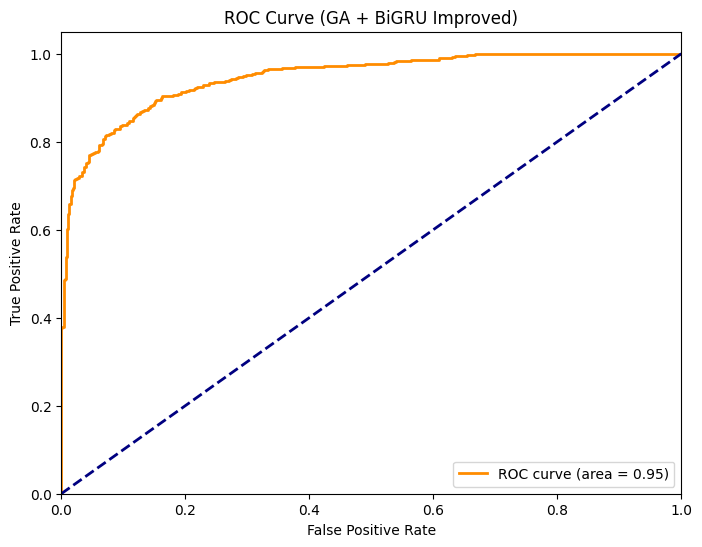

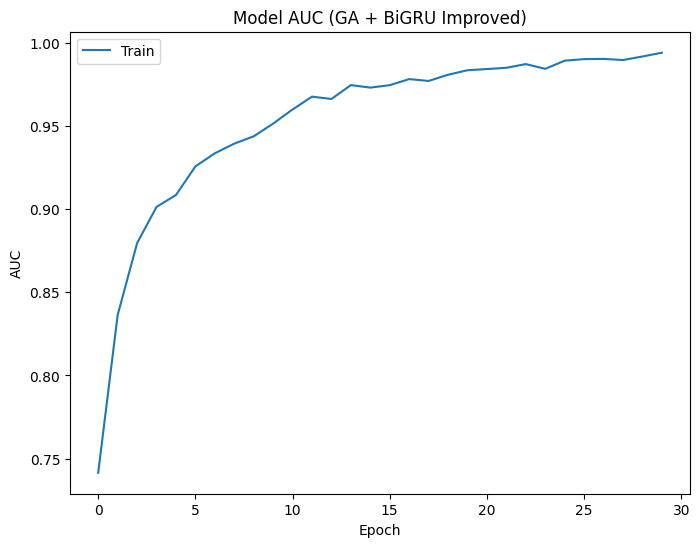

Model saved to GA_BiGRU_Improved.h5


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Bidirectional, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_score, recall_score, f1_score
from PIL import Image
import matplotlib.pyplot as plt
import gc

DATASET_PATH = "/content/drive/MyDrive/Multi_Dataset/deep/"
IMAGE_SIZE = (128, 128)
POPULATION_SIZE = 10
NUM_GENERATIONS = 10
MUTATION_RATE = 0.1
GA_EPOCHS = 30    # More epochs for deeper search
FINAL_EPOCHS = 50
GRU_BATCH_SIZE = 16
MAX_FEATURES = 200
MODEL_SAVE_PATH = "GA_BiGRU_Improved.h5"

def load_and_preprocess_data_custom(dataset_path, image_size):
    all_images, labels = [], []
    class_mapping = {
        'normal': 0, 'Normal': 0, '2- Control': 0, 'normalBT': 0, 'NormalBT': 0, 'normalMR': 0, 'NormalMR': 0,
        'stroke': 1, 'Stroke': 1, '1- Stroke': 1, 'strokeBT': 1, 'StrokeBT': 1, 'strokeMR': 1, 'StrokeMR': 1
    }
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(root, file)
                parent_folder = os.path.basename(os.path.dirname(image_path))
                label = class_mapping.get(parent_folder)
                if label is None:
                    grandparent_folder = os.path.basename(os.path.dirname(os.path.dirname(image_path)))
                    label = class_mapping.get(grandparent_folder)
                if label is not None:
                    try:
                        img = Image.open(image_path).convert('L')
                        img = img.resize(image_size)
                        img_array = np.array(img) / 255.0
                        all_images.append(img_array)
                        labels.append(label)
                    except Exception as e:
                        print(f"Error processing image {image_path}: {e}")
    df = pd.DataFrame({'image': all_images, 'label': labels})
    normal_df = df[df['label'] == 0].sample(n=min(len(df[df['label'] == 0]), len(df[df['label'] == 1])), random_state=42)
    stroke_df = df[df['label'] == 1].sample(n=min(len(df[df['label'] == 0]), len(df[df['label'] == 1])), random_state=42)
    balanced_df = pd.concat([normal_df, stroke_df]).sample(frac=1, random_state=42).reset_index(drop=True)
    print(f"Found {len(df)} total images. Balanced dataset has {len(balanced_df)} images.")
    return np.array(list(balanced_df['image'])), np.array(list(balanced_df['label']))

data, labels = load_and_preprocess_data_custom(DATASET_PATH, IMAGE_SIZE)
if len(data) == 0: exit()

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]*X_train.shape[2]))
X_test  = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]*X_test.shape[2]))
NUM_FEATURES = X_train.shape[2]

def create_chromosome(num_features):
    chromosome = np.zeros(num_features, dtype=int)
    indices = np.random.choice(num_features, min(MAX_FEATURES, num_features), replace=False)
    chromosome[indices] = 1
    np.random.shuffle(chromosome)
    return chromosome

def fitness_function(chromosome, X_train, y_train, X_val, y_val):
    sel = np.where(chromosome == 1)[0]
    if len(sel) == 0: return 0.0, None
    X_train_subset = X_train[:, :, sel]
    X_val_subset = X_val[:, :, sel]
    model = Sequential([
        Bidirectional(GRU(64, return_sequences=True), input_shape=(1, len(sel))),
        Dropout(0.3),
        Bidirectional(GRU(32, return_sequences=True)),
        Dropout(0.3),
        Bidirectional(GRU(16)),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
    history = model.fit(X_train_subset, y_train, epochs=GA_EPOCHS, batch_size=GRU_BATCH_SIZE, verbose=0)
    y_pred_val = model.predict(X_val_subset, verbose=0)
    auc = roc_auc_score(y_val, y_pred_val)
    tf.keras.backend.clear_session(); gc.collect()
    return auc, history

def selection(population, fitness_scores, num_parents):
    parents = []
    for _ in range(num_parents):
        tournament_size = 3
        tournament_indices = np.random.choice(len(population), tournament_size, replace=False)
        tournament_fitnesses = fitness_scores[tournament_indices]
        winner_index = tournament_indices[np.argmax(tournament_fitnesses)]
        parents.append(population[winner_index])
        fitness_scores[winner_index] = -1
    return np.array(parents)

def crossover(parents, population_size, num_features):
    offspring = []
    for _ in range(population_size-len(parents)):
        parent1, parent2 = random.choice(parents), random.choice(parents)
        crossover_point = random.randint(1, num_features-1)
        child = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
        offspring.append(child)
    return np.array(offspring)

def mutation(offspring, mutation_rate):
    mutated_offspring = [np.where(np.random.random(len(i)) < mutation_rate, 1-i, i) for i in offspring]
    return np.array(mutated_offspring)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
population = np.array([create_chromosome(NUM_FEATURES) for _ in range(POPULATION_SIZE)])
best_chromosome, best_fitness, best_history = None, -1.0, None
for generation in range(NUM_GENERATIONS):
    print(f"Generation {generation+1}/{NUM_GENERATIONS}")
    results = [fitness_function(chrom, X_train, y_train, X_val, y_val) for chrom in population]
    scores = np.array([res[0] if res[0] is not None else 0 for res in results])
    histories = [res[1] for res in results]
    curr_best = np.max(scores)
    curr_chrom = population[np.argmax(scores)]
    curr_hist = histories[np.argmax(scores)]
    if curr_best > best_fitness:
        best_fitness = curr_best
        best_chromosome = curr_chrom
        best_history = curr_hist
    print(f"  Best fitness in generation: {curr_best:.4f}")
    parents = selection(population, scores.copy(), POPULATION_SIZE//2)
    offspring = crossover(parents, POPULATION_SIZE, NUM_FEATURES)
    offspring = mutation(offspring, MUTATION_RATE)
    population[:len(parents)] = parents
    population[len(parents):] = offspring[:POPULATION_SIZE-len(parents)]

print("GA optimization complete.")

if best_chromosome is None or len(np.where(best_chromosome == 1)[0]) == 0:
    print("No valid chromosome found. Exiting."); exit()

sel = np.where(best_chromosome == 1)[0]
X_test_subset  = X_test[:, :, sel]
X_train_subset = X_train[:, :, sel]
final_model = Sequential([
    Bidirectional(GRU(64, return_sequences=True), input_shape=(1, len(sel))),
    Dropout(0.3),
    Bidirectional(GRU(32, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(GRU(16)),
    Dense(1, activation='sigmoid')
])
final_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC','Accuracy'])
history = final_model.fit(X_train_subset, y_train, epochs=FINAL_EPOCHS, batch_size=GRU_BATCH_SIZE, verbose=0)

y_pred_test = final_model.predict(X_test_subset, verbose=0)
y_pred_test_binary = (y_pred_test > 0.5).astype(int)
print(f"Test Accuracy (GA-BiGRU-Improved): {accuracy_score(y_test, y_pred_test_binary):.4f}")
print(f"Test AUC (GA-BiGRU-Improved): {roc_auc_score(y_test, y_pred_test):.4f}")
print(f"Test Precision (GA-BiGRU-Improved): {precision_score(y_test, y_pred_test_binary):.4f}")
print(f"Test Recall (GA-BiGRU-Improved): {recall_score(y_test, y_pred_test_binary):.4f}")
print(f"Test F1 Score (GA-BiGRU-Improved): {f1_score(y_test, y_pred_test_binary):.4f}")

fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve (GA + BiGRU Improved)')
plt.legend(loc="lower right"); plt.show()

if best_history is not None:
    plt.figure(figsize=(8, 6))
    plt.plot(best_history.history['AUC'])
    plt.title('Model AUC (GA + BiGRU Improved)')
    plt.ylabel('AUC'); plt.xlabel('Epoch')
    plt.legend(['Train'], loc='upper left'); plt.show()

final_model.save(MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")


In [ ]:
# Save the best chromosome as a NumPy file (with robust checks and download)
BEST_CHROM_FILE = "GA_BiGRU_best_chromosome.npy"

if best_chromosome is not None and np.any(best_chromosome):
    np.save(BEST_CHROM_FILE, best_chromosome)
    print(f"Best chromosome saved to {BEST_CHROM_FILE}")
    try:
        # For Google Colab: provide download link
        from google.colab import files
        files.download(BEST_CHROM_FILE)
    except ImportError:
        # Not running in Colab, so download won't work
        pass
else:
    print("No valid chromosome found to save.")


Best chromosome saved to GA_BiGRU_best_chromosome.npy


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model loaded successfully. ✅
Best chromosome loaded successfully. ✅


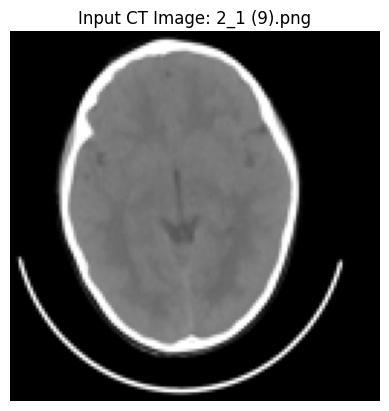

------------------------------
Prediction Probability: 0.0111
Predicted Class: Normal 🧠
------------------------------


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from PIL import Image

# ===========================================================================
# 1. Load Model & Chromosome
# ===========================================================================
MODEL_PATH = "GA_BiGRU_Improved.h5"     # Path to your improved model
CHROMOSOME_PATH = "GA_BiGRU_best_chromosome.npy"  # Path to your best chromosome

try:
    # Load the trained GA-BiGRU model
    model = load_model(MODEL_PATH)
    print("Model loaded successfully. ✅")
    # Load the best chromosome (feature selection mask)
    best_chromosome = np.load(CHROMOSOME_PATH)
    selected_features = np.flatnonzero(best_chromosome)
    print("Best chromosome loaded successfully. ✅")
except Exception as e:
    print(f"Error: {e}")
    print(f"Please ensure '{MODEL_PATH}' and '{CHROMOSOME_PATH}' exist in the working directory.")
    exit()

# ===========================================================================
# 2. Preprocessing Function for Prediction
# ===========================================================================
def preprocess_image(image_path, image_size=(128, 128), selected_features=None):
    """
    Loads, preprocesses, and resizes a single image for prediction.
    Applies the GA-selected features to the flattened image data.
    """
    try:
        img = Image.open(image_path).convert('L')
        img = img.resize(image_size)
        img_array = np.array(img) / 255.0
        # Show the image
        plt.imshow(img_array, cmap='gray')
        plt.title(f"Input CT Image: {os.path.basename(image_path)}")
        plt.axis('off')
        plt.show()
        # Flatten and select GA features
        flat_img = img_array.flatten()
        if selected_features is not None:
            flat_img = flat_img[selected_features]
        # Reshape for (samples, time steps, features)
        return flat_img.reshape(1, 1, -1)
    except Exception as e:
        print(f"Error processing image: {e}")
        return None

# ===========================================================================
# 3. Prediction
# ===========================================================================
# The path of the image you want to predict
image_path = "/content/2_1 (9).png"

processed_img = preprocess_image(image_path, selected_features=selected_features)

if processed_img is not None:
    pred_prob = model.predict(processed_img, verbose=0)[0][0]
    pred_class = "Stroke" if pred_prob > 0.5 else "Normal"
    print("-" * 30)
    print(f"Prediction Probability: {pred_prob:.4f}")
    print(f"Predicted Class: {pred_class} 🧠")
    print("-" * 30)
else:
    print("Failed to process image. No prediction made.")
